In [1]:
import os
import io
import trimesh
import b3d
import b3d.bayes3d as bayes3d
import fire
import genjax
import jax
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
from b3d import Pose
from genjax import Pytree
from b3d import Mesh, Pose
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
genjax.pretty()

In [2]:
rr.init("demo")
rr.connect("127.0.0.1:8812")

In [3]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

hdf5_file_path = os.path.join(physion_assets_path,
    "hdf5s/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0012.hdf5",
)

In [4]:
def cart2sphe(cart):
    """ Convert cartesian coordinates to spherical coordinates (Y-up) """
    hypot_xz = np.hypot(cart['x'], cart['z'])
    sphe = {
        'azimuth': np.arctan2(cart['z'], cart['x']),
        'elevation': np.arctan2(cart['y'], hypot_xz),
        'radius': np.hypot(hypot_xz, cart['y'])
    }
    return sphe

def sphe2cart(sphe):
    """ Convert spherical coordinates to cartesian coordinates (Y-up)"""
    hypot_xz = sphe['radius'] * np.cos(sphe['elevation'])
    cart = {
        'x': hypot_xz * np.cos(sphe['azimuth']),
        'z': hypot_xz * np.sin(sphe['azimuth']),
        'y': sphe['radius'] * np.sin(sphe['elevation']),
    }
    return cart

In [5]:
vfov = 55 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_pose = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0'])
    projection_matrix = np.array(f['frames']['0010']['camera_matrices']['projection_matrix_cam0'])
    # camera_matrix = np.linalg.inv(camera_matrix.reshape((4, 4)))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    distractors = np.array(f['static']['distractors'])
    occluders = np.array(f['static']['occluders'])
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])
    meshes_faces = [np.array(f['static']['mesh'][f'faces_{idx}']) for idx in range(len(object_ids))]
    meshes_vertices = [np.array(f['static']['mesh'][f'vertices_{idx}']) for idx in range(len(object_ids))]

In [6]:
projection_matrix.reshape((4, 4))

array([[ 1.9209819,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  1.9209819,  0.       ,  0.       ],
       [ 0.       ,  0.       , -1.002002 , -0.2002002],
       [ 0.       ,  0.       , -1.       ,  0.       ]], dtype=float32)

In [7]:
camera_matrix.reshape((4, 4))

array([[-8.7257326e-01,  0.0000000e+00, -4.8848364e-01, -1.7881393e-07],
       [ 3.2985500e-01,  7.3757690e-01, -5.8921647e-01,  2.9802322e-08],
       [-3.6029425e-01,  6.7526317e-01,  6.4358997e-01, -2.3322058e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [8]:
FINAL_T, height, width

(145, 1024, 1024)

In [9]:
object_ids, model_names, distractors, occluders

(array([1, 2, 3, 4, 5]),
 array([b'cube', b'cube', b'cube', b'chair_thonet_marshall', b'vase_03'],
       dtype=object),
 array([b'chair_thonet_marshall'], dtype=object),
 array([b'vase_03'], dtype=object))

In [10]:
for i in initial_position:
    print(i)

[0.85 0.   0.  ]
[0.25 0.   0.  ]
[-0.25  0.    0.  ]
[ 0.37436676  0.         -1.        ]
[-0.51430506  0.          0.91869754]


In [11]:
for i in initial_rotation:
    print(i)

[0. 0. 0.]
[0. 0. 0.]
[ 0.       11.613795  0.      ]
[ 0.        -3.7296226  0.       ]
[  0.      113.39555   0.     ]


In [12]:
for i in scales:
    print(i)

[0.5  0.01 2.  ]
[0.1  0.5  0.25]
[0.1       0.4793447 0.2752273]
[1. 1. 1.]
[2.3146927 2.3146927 2.3146927]


In [13]:
for i in meshes_faces:
    print(i)

[[ 0  1  2]
 [ 3  1  0]
 [ 3  4  1]
 [ 5  3  0]
 [ 6  4  3]
 [ 6  7  4]
 [ 6  8  7]
 [ 9  3  5]
 [ 9  6  3]
 [10  9  5]
 [10 11  9]
 [12  8  6]
 [ 9 12  6]
 [11 12  9]
 [12 13  8]
 [11 14 12]
 [14 13 12]
 [14 15 13]
 [16 17 18]
 [19 17 16]
 [19 20 17]
 [21 19 16]
 [22 20 19]
 [22 23 20]
 [22 24 23]
 [25 19 21]
 [25 22 19]
 [26 25 21]
 [26 27 25]
 [28 24 22]
 [25 28 22]
 [27 28 25]
 [28 29 24]
 [27 30 28]
 [30 29 28]
 [30 31 29]
 [32 33 34]
 [35 33 32]
 [35 36 33]
 [37 35 32]
 [38 36 35]
 [38 39 36]
 [38 40 39]
 [41 35 37]
 [41 38 35]
 [42 41 37]
 [42 43 41]
 [44 40 38]
 [41 44 38]
 [43 44 41]
 [44 45 40]
 [43 46 44]
 [46 45 44]
 [46 47 45]
 [48 49 50]
 [51 49 48]
 [51 52 49]
 [53 51 48]
 [54 52 51]
 [54 55 52]
 [54 56 55]
 [57 51 53]
 [57 54 51]
 [58 57 53]
 [58 59 57]
 [60 56 54]
 [57 60 54]
 [59 60 57]
 [60 61 56]
 [59 62 60]
 [62 61 60]
 [62 63 61]
 [64 65 66]
 [67 65 64]
 [67 68 65]
 [69 67 64]
 [70 68 67]
 [70 71 68]
 [70 72 71]
 [73 67 69]
 [73 70 67]
 [74 73 69]
 [74 75 73]
 [76

In [14]:
for i in meshes_vertices:
    print(i.shape)

(96, 3)
(96, 3)
(96, 3)
(20370, 3)
(2587, 3)


In [15]:
image_width, image_height = int(height), int(width)
fx, fy, cx, cy, near, far = (
    float(fx),
    float(fy),
    float(image_width/2.0),
    float(image_height/2.0),
    float(near_plane),
    float(far_plane),
)

In [16]:
fx, fy, cx, cy, near, far, image_width, image_height

(983.542849009237, 983.542849009237, 512.0, 512.0, 0.1, 100.0, 1024, 1024)

In [17]:
def scale_mesh(vertices, scale_factor):
    vertices[:, 0] *= scale_factor[0]
    vertices[:, 1] *= scale_factor[1]
    vertices[:, 2] *= scale_factor[2]
    return vertices

In [18]:
excluded_model_ids = np.concatenate((np.where(model_names==distractors), np.where(model_names==occluders)), axis=0)
included_model_names = [model_names[idx] for idx in range(len(object_ids)) if idx not in excluded_model_ids]
included_model_ids = [object_ids[idx]-1 for idx in range(len(object_ids)) if idx not in excluded_model_ids]


In [19]:
excluded_model_ids, included_model_names, included_model_ids

(array([[3],
        [4]]),
 [b'cube', b'cube', b'cube'],
 [0, 1, 2])

In [20]:
object_initial_positions = [np.array([pos[0],pos[2],pos[1]]) for idx, pos in enumerate(initial_position) if idx in included_model_ids]
object_initial_rotations = [rot for idx, rot in enumerate(initial_rotation) if idx in included_model_ids]
object_scales = [scale for idx, scale in enumerate(scales) if idx in included_model_ids]
# object_meshes = [(vertex, face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]
object_meshes = [(scale_mesh(vertex, object_scales[idx]), face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]


In [21]:
for i in object_initial_positions:
    print(i)

[0.85 0.   0.  ]
[0.25 0.   0.  ]
[-0.25  0.    0.  ]


In [22]:
for i in object_initial_rotations:
    print(i)

[0. 0. 0.]
[0. 0. 0.]
[ 0.       11.613795  0.      ]


In [23]:
for i in object_scales:
    print(i)

[0.5  0.01 2.  ]
[0.1  0.5  0.25]
[0.1       0.4793447 0.2752273]


In [24]:
for i in object_meshes:
    print(i)

(array([[ 0.25      ,  0.01      ,  0.333334  ],
       [ 0.0833335 ,  0.01      ,  1.        ],
       [ 0.25      ,  0.01      ,  1.        ],
       [ 0.0833335 ,  0.01      ,  0.333334  ],
       [-0.0833335 ,  0.01      ,  1.        ],
       [ 0.25      ,  0.01      , -0.333334  ],
       [-0.0833335 ,  0.01      ,  0.333334  ],
       [-0.25      ,  0.01      ,  1.        ],
       [-0.25      ,  0.01      ,  0.333334  ],
       [ 0.0833335 ,  0.01      , -0.333334  ],
       [ 0.25      ,  0.01      , -1.        ],
       [ 0.0833335 ,  0.01      , -1.        ],
       [-0.0833335 ,  0.01      , -0.333334  ],
       [-0.25      ,  0.01      , -0.333334  ],
       [-0.0833335 ,  0.01      , -1.        ],
       [-0.25      ,  0.01      , -1.        ],
       [-0.25      ,  0.        ,  0.333334  ],
       [-0.0833335 ,  0.        ,  1.        ],
       [-0.25      ,  0.        ,  1.        ],
       [-0.0833335 ,  0.        ,  0.333334  ],
       [ 0.0833335 ,  0.        ,  1.  

In [25]:
# path = os.path.join(
#     b3d.get_root_path(),
#     "assets/shared_data_bucket/input_data/shout_on_desk.r3d.video_input.npz",
# )
# video_input = b3d.io.VideoInput.load(path)

# # Get intrinsics
# image_width, image_height, fx, fy, cx, cy, near, far = np.array(
#     video_input.camera_intrinsics_depth
# )
# image_width, image_height = int(image_width), int(image_height)
# fx, fy, cx, cy, near, far = (
#     float(fx),
#     float(fy),
#     float(cx),
#     float(cy),
#     float(near),
#     float(far),
# )

# # Get RGBS and Depth
# rgbs = video_input.rgb[::4] / 255.0
# xyzs = video_input.xyz[::4]

In [26]:
# image_width, image_height

In [27]:
# fx, fy, cx, cy, near, far

In [28]:
# object_initial_positions

In [29]:
for vertices, faces in object_meshes:
    print(vertices.shape)

(96, 3)
(96, 3)
(96, 3)


In [30]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


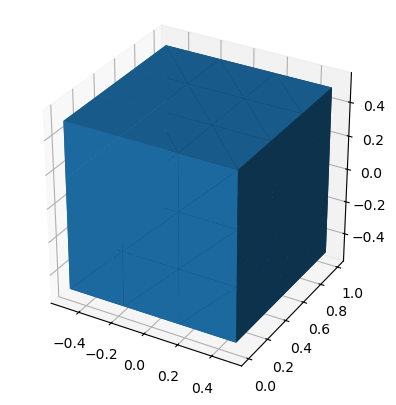

In [31]:
for model_name in set(included_model_names):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    trim = trimesh.load(os.path.join(physion_assets_path, f"all_flex_meshes/{model_name.decode('UTF-8')}.obj",))
    ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,1], trim.vertices[:,2], triangles=trim.faces)
    set_axes_equal(ax)

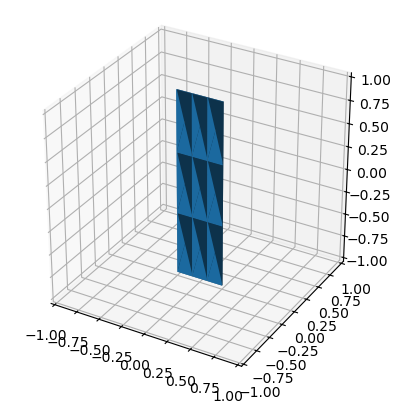

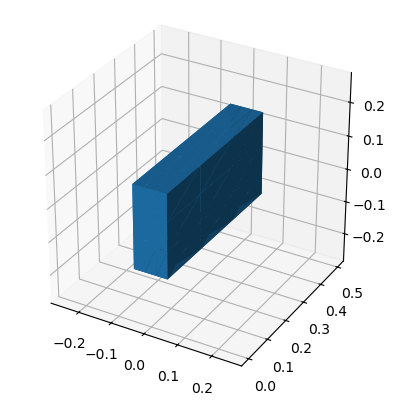

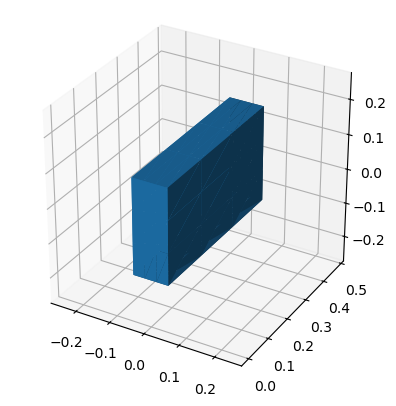

In [32]:

for vertices, faces in object_meshes:
    trim = trimesh.Trimesh(vertices=vertices, faces=faces)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,1], trim.vertices[:,2], triangles=trim.faces)
    set_axes_equal(ax)


In [33]:
# object_library = bayes3d.MeshLibrary.make_empty_library()
# for model_name, (vertices, faces) in zip(included_model_names, object_meshes):
#     # print(model_name)
#     # mesh = trimesh.load(os.path.join(physion_assets_path, f"all_flex_meshes/{model_name.decode('UTF-8')}.obj",))
#     # vertex_colors = jnp.array(mesh.visual.vertex_colors)[..., :3] / 255.0
#     # print(vertex_colors, vertex_colors.shape)
#     vertices_centered = vertices - jnp.mean(vertices, axis=0)
#     print(jnp.mean(vertices, axis=0))
#     vertex_colors = jnp.full(vertices_centered.shape, 0.4)
#     # print(vertex_colors, vertex_colors.shape)
    
#     # print(jnp.array(vertices).shape)
#     object_library.add_object(vertices_centered, jnp.array(faces), vertex_colors)
# print(f"{object_library.get_num_objects()} objects in library")

In [34]:
# # load original meshes without scaling
# object_library = bayes3d.MeshLibrary.make_empty_library()

# for vertex, face in object_meshes:
#     object_library.add_trimesh(trimesh.Trimesh(vertices=vertex, faces=face))

# print(f"{object_library.get_num_objects()} objects in library")

In [35]:
# load original meshes without scaling
object_library = bayes3d.MeshLibrary.make_empty_library()

for model_name in set(included_model_names):
    object_library.add_trimesh(trimesh.load(os.path.join(physion_assets_path, f"all_flex_meshes/{model_name.decode('UTF-8')}.obj",)))

print(f"{object_library.get_num_objects()} objects in library")

# # load original meshes without scaling
# object_library = bayes3d.MeshLibrary.make_empty_library()

# for model_name in included_model_names:
#     object_library.add_trimesh(trimesh.load(os.path.join(physion_assets_path, f"all_flex_meshes/{model_name.decode('UTF-8')}.obj",)))

# print(f"{object_library.get_num_objects()} objects in library")

1 objects in library


In [36]:
# Gridding on translation only.
translation_deltas = Pose.concatenate_poses(
    [
        jax.vmap(lambda p: Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-0.1, 0.1, 11),
                    jnp.linspace(-0.1, 0.1, 11),
                    jnp.linspace(-0.1, 0.1, 11),
                ),
                axis=-1,
            ).reshape(-1, 3)
        ),
        Pose.identity()[None, ...],
    ]
)
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses(
    [
        jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
            jax.random.split(jax.random.PRNGKey(0), 11 * 11 * 11),
            Pose.identity(),
            0.00001,
            1000.0,
        ),
        Pose.identity()[None, ...],
    ]
)
all_deltas = Pose.stack_poses([translation_deltas, rotation_deltas])


In [37]:
# translation_deltas

In [38]:
# rotation_deltas

In [39]:
# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)
model = bayes3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
color_error, depth_error = (1e100, 5)
inlier_score, outlier_prob = (5.0, 0.00001)
color_multiplier, depth_multiplier = (10000.0, 500.0)
model_args = bayes3d.ModelArgs(
    color_error,
    depth_error,
    inlier_score,
    outlier_prob,
    color_multiplier,
    depth_multiplier,
)

/home/hlwang_ipe_genjax/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [40]:
def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """

    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.abs(np.array([x, y, z, w]))

In [41]:
# Pose.identity()

In [42]:
# image_arr[0]

In [43]:
jnp.asarray(object_initial_positions[0])

<Array([0.85, 0.  , 0.  ], dtype=float32)
  <Arrayviz rendering>
>

In [44]:
object_initial_rotations[2]

array([ 0.      , 11.613795,  0.      ], dtype=float32)

In [45]:
euler_angles_to_quaternion(object_initial_rotations[2])

array([0.        , 0.10117607, 0.        , 0.99486854])

In [46]:
depth_arr[0]

<jax.Array float32(1024, 1024) ≈2.6 ±1.0 [≥1.0, ≤5.4] nonzero:1_048_576
  <Arrayviz rendering>
>

In [47]:
# Initial trace for timestep 0
START_T = 0
trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.ChoiceMap.d(
        dict(
            [
                ("camera_pose", Pose.identity()),
                ("object_pose_0", Pose(jnp.asarray(object_initial_positions[0]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[0])))),
                ("object_pose_1", Pose(jnp.asarray(object_initial_positions[1]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[1])))),
                ("object_pose_2", Pose(jnp.asarray(object_initial_positions[2]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[2])))),
                ("object_0", 0),
                ("object_1", 1),
                ("object_2", 2),
                (
                    "observed_rgb_depth",
                    (image_arr[START_T], depth_arr[START_T]),
                ),
            ]
        )
    ),
    (jnp.arange(3), model_args, object_library),
)

/home/hlwang_ipe_genjax/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/jax/_src/abstract_arrays.py:68: RuntimeWarning: overflow encountered in cast
  return canonical_concrete_aval(np.array(x, dtype=dtype), weak_type=weak_type)
/home/hlwang_ipe_genjax/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:158: RuntimeWarning: overflow encountered in cast
  return np.asarray(


Better looking printing: [[[0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  ...
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]]

 [[0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999995 0.39999995 0.39999995]
  ...
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999995 0.39999995 0.39999995]]

 [[0.39999998 0.39999998 0.39999998]
  [0.4        0.4        0.4       ]
  [0.39999998 0.39999998 0.39999998]
  ...
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]]

 ...

 [[0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999995 0.39999995 0.39999995]
  ...
  [0.39999995 0.39999995 0.39999995]
  [0.39999998 0.39999998 0.39999998]
  [0.4        0.4        0.4       ]]

 [[0.39999998 0.39999998 0.39999998]
  [0.3999999

In [49]:
# # Initial trace for timestep 0
# START_T = 0
# trace, _ = importance_jit(
#     jax.random.PRNGKey(0),
#     genjax.ChoiceMap.d(
#         dict(
#             [
#                 ("camera_pose", Pose(jnp.array([-0.5499, 2.413, 1.4528]), jnp.array([0.0, 0.0, 0.5, 1.0]))),
#                 ("object_pose_0", Pose(jnp.asarray(object_initial_positions[0]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[0])))),
#                 ("object_pose_1", Pose(jnp.asarray(object_initial_positions[1]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[1])))),
#                 ("object_pose_2", Pose(jnp.asarray(object_initial_positions[2]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[2])))),
#                 ("object_0", 0),
#                 ("object_1", 1),
#                 ("object_2", 2),
#                 (
#                     "observed_rgb_depth",
#                     (image_arr[START_T], depth_arr[START_T]),
#                 ),
#             ]
#         )
#     ),
#     (jnp.arange(3), model_args, object_library),
# )

In [48]:
bayes3d.rerun_visualize_trace_t(trace, 0)

Better looking printing: [[[0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  ...
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]]

 [[0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999995 0.39999995 0.39999995]
  ...
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999995 0.39999995 0.39999995]]

 [[0.39999998 0.39999998 0.39999998]
  [0.4        0.4        0.4       ]
  [0.39999998 0.39999998 0.39999998]
  ...
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]]

 ...

 [[0.39999998 0.39999998 0.39999998]
  [0.39999998 0.39999998 0.39999998]
  [0.39999995 0.39999995 0.39999995]
  ...
  [0.39999995 0.39999995 0.39999995]
  [0.39999998 0.39999998 0.39999998]
  [0.4        0.4        0.4       ]]

 [[0.39999998 0.39999998 0.39999998]
  [0.3999999

In [49]:
depth_arr[START_T]

<jax.Array float32(1024, 1024) ≈2.6 ±1.0 [≥1.0, ≤5.4] nonzero:1_048_576
  <Arrayviz rendering>
>

In [48]:
depth_arr[0]

<jax.Array float32(1024, 1024) ≈2.6 ±1.0 [≥1.0, ≤5.4] nonzero:1_048_576
  <Arrayviz rendering>
>

In [28]:
trace

StaticTrace(...)

In [35]:
trace.get_retval()

((<jax.Array uint8(1024, 1024, 3) [≥0, ≤244] zero:19_067 nonzero:3_126_661
    <Arrayviz rendering>
  >,
  <jax.Array float32(1024, 1024, 3) ≈0.4 ±9e-08 [≥0.4, ≤0.4] nonzero:3_145_728
    <Arrayviz rendering>
  >),
 (<jax.Array float32(1024, 1024) ≈2.6 ±1.0 [≥1.0, ≤5.4] nonzero:1_048_576
    <Arrayviz rendering>
  >,
  <jax.Array float32(1024, 1024) ≈0.46 ±0.027 [≥0.41, ≤0.5] nonzero:1_048_576
    <Arrayviz rendering>
  >))

In [30]:
# Visualize trace
bayes3d.rerun_visualize_trace_t(trace, 0)


In [ ]:
ACQUISITION_T = 90
for T_observed_image in tqdm(range(ACQUISITION_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices(
        trace,
        Pytree.const(["observed_rgb_depth"]),
        (rgbs_resized[T_observed_image], xyzs[T_observed_image, ..., 2]),
    )
    trace, key = bayes3d.enumerate_and_select_best_move(
        trace, Pytree.const(("camera_pose",)), key, all_deltas
    )
    bayes3d.rerun_visualize_trace_t(trace, T_observed_image)


In [ ]:
# Outliers are AND of the RGB and Depth outlier masks
_inliers, _color_inliers, _depth_inliers, outliers, _undecided, _valid_data_mask = (
    bayes3d.get_rgb_depth_inliers_from_trace(trace)
)
outlier_mask = outliers
rr.log("outliers", rr.Image(jnp.tile((outlier_mask * 1.0)[..., None], (1, 1, 3))))

# Get the point cloud corresponding to the outliers
rgb, depth = trace.get_choices()["observed_rgb_depth"]
point_cloud = b3d.xyz_from_depth(depth, fx, fy, cx, cy)[outlier_mask]
point_cloud_colors = rgb[outlier_mask]

# Segment the outlier cloud.
assignment = b3d.segment_point_cloud(point_cloud)

# Only keep the largers cluster in the outlier cloud.
point_cloud = point_cloud.reshape(-1, 3)[assignment == 0]
point_cloud_colors = point_cloud_colors.reshape(-1, 3)[assignment == 0]

# Create new mesh.
vertices, faces, vertex_colors, _face_colors = (
    b3d.make_mesh_from_point_cloud_and_resolution(
        point_cloud, point_cloud_colors, point_cloud[:, 2] / fx * 2.0
    )
)
object_pose = Pose.from_translation(vertices.mean(0))
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)

In [ ]:
object_library

In [ ]:
object_library.ranges

In [ ]:
len(object_library.ranges)

In [ ]:
single_object_trace = trace
trace = single_object_trace

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.ChoiceMap.d(
        dict(
            [
                ("camera_pose", trace.get_choices()["camera_pose"]),
                ("object_pose_0", trace.get_choices()["object_pose_0"]),
                ("object_pose_1", trace.get_choices()["camera_pose"] @ object_pose),
                ("object_0", 0),
                ("object_1", 1),
                (
                    "observed_rgb_depth",
                    (rgbs_resized[ACQUISITION_T], xyzs[ACQUISITION_T, ..., 2]),
                ),
            ]
        )
    ),
    (jnp.arange(2), model_args, object_library),
)

In [ ]:
# Visualize trace
bayes3d.rerun_visualize_trace_t(trace, ACQUISITION_T)

In [ ]:
FINAL_T = len(xyzs)
for T_observed_image in tqdm(range(ACQUISITION_T, FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices(
        trace,
        Pytree.const(("observed_rgb_depth",)),
        (rgbs_resized[T_observed_image], xyzs[T_observed_image, ..., 2]),
    )
    trace, key = bayes3d.enumerate_and_select_best_move(
        trace, Pytree.const(("camera_pose",)), key, all_deltas
    )
    trace, key = bayes3d.enumerate_and_select_best_move(
        trace, Pytree.const(("object_pose_1",)), key, all_deltas
    )
    bayes3d.rerun_visualize_trace_t(trace, T_observed_image)
